In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import cv2
from tqdm.auto import tqdm
import math
import torch
import albumentations as A
import cv2
import os
import torchvision
import lightning as L
import torchmetrics

/home/torfinhell/.conda/envs/DL/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/torfinhell/.conda/envs/DL/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
BATCH_SIZE=32
WINDOW_SIZE=(100, 100)
BASE_LR=1e-4
MAX_EPOCHS=100
LABEL_SMOOTHING=0.1
if(torch.cuda.is_available()):
    DEVICE=torch.device("cuda")
else:
    DEVICE=torch.device("cpu")

In [3]:
from torch.utils import data 
import random
class MyDataset(data.Dataset):
    def __init__(self,
                 mode, 
                 root_images, 
                 root_images_info,
                 train_fraction=0.8, 
                 split_seed=42,
                 transform=None):
        super().__init__()
        rng=random.Random(split_seed)
        image_info=pd.read_csv(root_images_info+"/gt.csv")
        paths_by_class=[group['filename'].tolist() for _, group in image_info.groupby("class_id")]
        self.num_classes=len(paths_by_class)
        for index in range(len(paths_by_class)):
            rng.shuffle(paths_by_class[index])
            split_train=int(train_fraction*len(paths_by_class[index]))
            if(mode=="train"):
                paths_by_class[index]=paths_by_class[index][:split_train]
            elif(mode=="valid"):
                paths_by_class[index]=paths_by_class[index][split_train:]
            else:
                raise ValueError("Mode is not train or valid")
        self.paths, self.labels=zip(*[(path, index)  for index in range(len(paths_by_class)) for path in paths_by_class[index]])
        self.paths, self.labels=list(self.paths), list(self.labels)
        combined=list(zip(self.paths, self.labels))
        rng.shuffle(combined)
        self.paths, self.labels=zip(*combined)
        self.paths=[f"{root_images}/{path}" for path in self.paths]
        self._transform=transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, index):
        img_path=self.paths[index]
        label=self.labels[index]
        image=np.array(PIL.Image.open(img_path).convert("RGB"))
        if(self._transform):
            image=self._transform(image=image)["image"]
        return image, label

In [4]:
from albumentations.pytorch import ToTensorV2
MEAN_DATASET=[0.485, 0.456, 0.406]
STD_DATASET=[0.229, 0.224, 0.225]
image_dir="./tests/00_test_img_input/train/images"#test is the same as train
images_info="./tests/00_test_img_gt"
augmentations=[
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(-45, 45))
]
common_transform=[
    A.Resize(height=232, width=232, interpolation=cv2.INTER_LINEAR),
    A.CenterCrop(height=224, width=224),
    A.Normalize(mean=MEAN_DATASET, std=STD_DATASET),
    ToTensorV2()
]
AUGMENT_TRANSFORM=A.Compose(augmentations)
TRAIN_TRANSFORM=A.Compose(augmentations+common_transform)
VALID_TRANSFORM=A.Compose(common_transform)
ds_train = MyDataset("train", image_dir, images_info,transform=TRAIN_TRANSFORM)
ds_valid = MyDataset("valid", image_dir, images_info,transform=VALID_TRANSFORM)
ds_train_show = MyDataset("train", image_dir, images_info,transform=AUGMENT_TRANSFORM)
ds_valid_show = MyDataset("valid", image_dir, images_info,transform=AUGMENT_TRANSFORM)
NUM_CLASSES=ds_train.num_classes

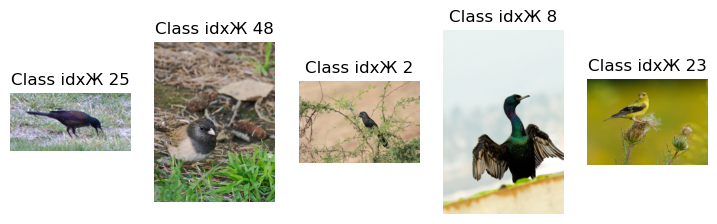

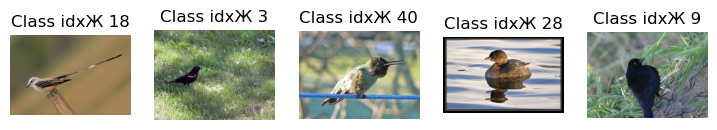

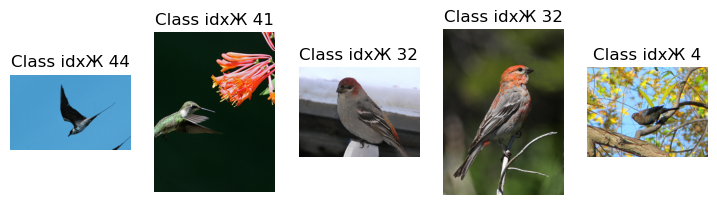

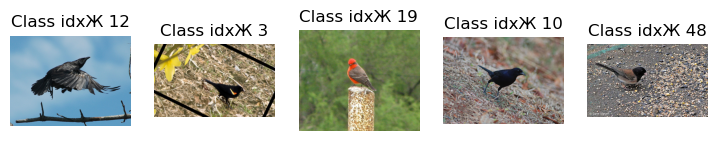

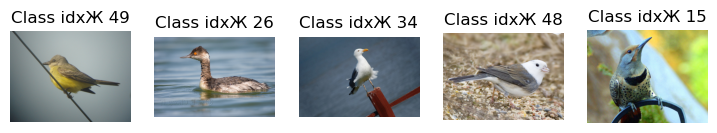

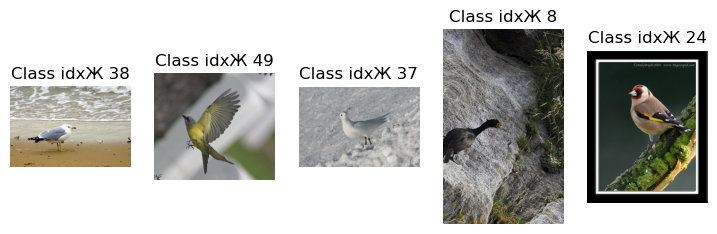

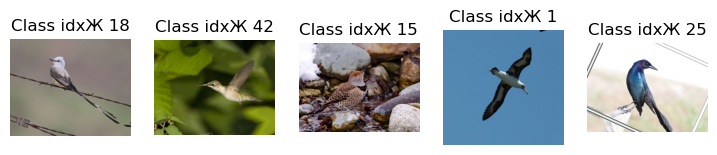

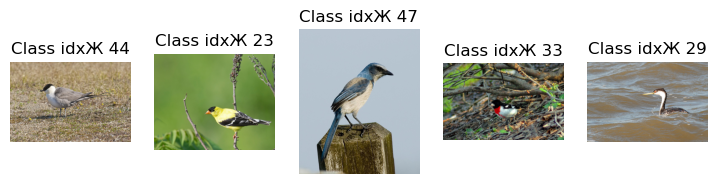

In [5]:
def show_multiple_images(ds, n=10):
    cols=min(n, 5)
    rows=(n+cols-1)//cols
    for i in range(rows):
        plt.figure(figsize=(9, 4))
        for j in range(cols):
            plt.subplot(1, cols, j+1)
            plt.imshow(ds[i*cols+j][0])
            plt.title(f"Class idxЖ {ds[i*cols+j][1]}")
            plt.axis("off")
        plt.show()
show_multiple_images(ds_train_show, 40)

In [6]:
dl_train=data.DataLoader(
    ds_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=os.cpu_count(),
)
dl_valid=data.DataLoader(
    ds_valid, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=os.cpu_count(),
)

In [7]:
%reload_ext tensorboard
%tensorboard --logdir=runs/

In [8]:
def get_mobile_net_v2(num_classes, transfer=True):
    weights =torchvision.models.MobileNet_V2_Weights.DEFAULT if transfer else None
    model=torchvision.models.mobilenet_v2(weights=weights)
    linear_size=model.classifier[1].in_features
    model.classifier[1]=nn.Linear(linear_size, num_classes)
    return model

In [9]:
class LightningBirdClassifier(L.LightningModule):
    def __init__(self, transfer=True, lr=BASE_LR):
        super().__init__()
        self.transfer=transfer
        self.num_classes=NUM_CLASSES
        self.model=self.get_model()
        self.loss_fn=nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
        self.lr=lr
        self.accuracy=torchmetrics.classification.Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES
        )
    def get_model(self):
        return get_mobile_net_v2(self.num_classes, self.transfer)
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)
    def training_step(self, batch):
        return self._step(batch, "train")
    def validation_step(self, batch):
        return self._step(batch, "valid")
    def _step(self, batch, kind):
        x, y=batch
        p=self.model(x)
        loss=self.loss_fn(p, y)
        accs=self.accuracy(p.argmax(axis=-1), y)
        return self._log_metrics(loss, accs, kind)
    def _log_metrics(self, loss, accs, kind):
        metrics={}
        if loss is not None:
            metrics[f"{kind}_loss"]=loss
        if accs is not None:
            metrics[f"{kind}_accs"]=accs
        self.log_dict(
            metrics,
            prog_bar=True,
            logger=True,
            on_step=False,
            on_epoch=True
        )
        return loss


In [10]:
def train_model(
    model,
    experiment_path,
    dl_train,
    dl_valid,
    max_epochs=MAX_EPOCHS,
):
    callbacks = [
        L.pytorch.callbacks.TQDMProgressBar(leave=True),
        L.pytorch.callbacks.ModelCheckpoint(
            filename="{epoch}-{valid_accs:.3f}",
            monitor="valid_accs",
            mode="max",
            save_top_k=1,
            save_last=True,
        ),
    ]
    trainer = L.Trainer(
        callbacks=callbacks,
        max_epochs=max_epochs,
        default_root_dir=experiment_path,
    )
    trainer.fit(model, dl_train, dl_valid)

In [11]:
train_model(
    LightningBirdClassifier(),
    "runs/basic",
    dl_train,
    dl_valid,
    max_epochs=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-09-05 22:44:14.261807: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-05 22:44:14.283542: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
202

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/torfinhell/.conda/envs/DL/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [12]:
def get_frozen(num_classes, transfer=True, unfreeze="most"):
    mobile_net_v2=get_mobile_net_v2(num_classes, transfer)
    unfreeze_params={
        "last":-1,
        "last_2":-2,
        "most":-4,
        "full":0
    }
    assert unfreeze in unfreeze_params.keys()
    for child in list(mobile_net_v2.children())[:unfreeze_params[unfreeze]]:
        for param in child.parameters():
            param.requires_grad=False
    return mobile_net_v2 

In [13]:
class LightningBirdClassifierFrozen(LightningBirdClassifier):
    def __init__(self, unfreeze="most",**other_kwargs):
        self.unfreeze=unfreeze
        super().__init__(**other_kwargs)
    def get_model(self):
        return get_frozen(
            NUM_CLASSES,
            self.transfer,
            self.unfreeze
        )

In [14]:
for unfreeze in ["most", "last","last_2", "full"]:
    train_model(
        LightningBirdClassifierFrozen(unfreeze=unfreeze),
        f"runs/unfreeze_{unfreeze}",
        dl_train,
        dl_valid,
        max_epochs=10
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | MobileNetV2        | 2.3 M  | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.152     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | MobileNetV2        | 2.3 M  | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
64.0 K    Trainable params
2.2 M     Non-trainable params
2.3 M     Total params
9.152     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | MobileNetV2        | 2.3 M  | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.152     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | MobileNetV2        | 2.3 M  | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.152     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [15]:
train_model(
        LightningBirdClassifierFrozen(unfreeze="most"),
        f"runs/unfreeze_Most_40_epochs",
        dl_train,
        dl_valid,
        max_epochs=40
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | MobileNetV2        | 2.3 M  | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.152     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [16]:
def mixup_data(x, y, alpha):
    lam=np.random.beta(alpha, alpha)
    x_size=x.size()[0]
    index=torch.randperm(x_size, device=x.device)
    mixed_x=lam*x+(1-lam)*x[index, ...]
    y, y_other=y, y[index]
    return mixed_x, y, y_other, lam
def mixed_loss(loss_fn, p, y, y_other, lam):
    return lam *loss_fn(p, y)+(1-lam)*loss_fn(p, y_other)
class LightningBirdClassifierFrozenMixUp(LightningBirdClassifierFrozen):
    def __init__(self, alpha=1.0, **other_kwargs):
        super().__init__(**other_kwargs)
        self.alpha=alpha
    def _step(self, batch, kind):
        x, y=batch
        mixed_x, y, y_other, lam=mixup_data(x, y, self.alpha)
        p=self.model(mixed_x)
        loss=mixed_loss(self.loss_fn, p, y, y_other, lam)
        accs=self.accuracy(self.model(x).argmax(axis=-1), y)
        return self._log_metrics(loss, accs, kind)
        

In [17]:
train_model(
        LightningBirdClassifierFrozen(unfreeze="most"),
        f"runs/unfreeze_Most_40_epochs",
        dl_train,
        dl_valid,
        max_epochs=40
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | MobileNetV2        | 2.3 M  | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.152     Total estimated model params size (MB)
215       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
